In [ ]:
import os
import random
import numpy as np
from numpy import genfromtxt
import pandas as pd
import math
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import sys
import shutil
import warnings

In [ ]:
if 'google.colab' in str(get_ipython()):

  # To run in Gogogle Colab
  # You have to create a folder IFT6759 in your google drive 
  # and put all content of the folder ift-6759-forecast-project 

  #@title Mount your Google Drive

  %matplotlib inline
  %load_ext autoreload
  %autoreload 2

  from google.colab import drive
  drive.mount("/content/gdrive", force_remount=True)

  folder = "/content/gdrive/MyDrive/IFT6759" #@param {type:"string"}
  !ln -Ts $folder /content/IFT6759 2> /dev/null

  # Add the assignment folder to Python path
  if '/content/IFT6759' not in sys.path:
      sys.path.insert(0, '/content/IFT6759')

  sys.path.insert(0,'/content/gdrive/MyDrive/IFT6759/functions')
  import utils
  import load_creator
  sys.path.insert(0,'/content/gdrive/MyDrive/IFT6759/models')
  import SUNSET
  import convGRU

else:

  import models.SUNSET as SUNSET
  import models.convGRU as convGRU
  import functions.utils as utils
  import functions.load_creator as load_creator

Mounted at /content/gdrive


In [ ]:
# Create device to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# set Random seed

seed = 10
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if device.type=='cuda':
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
# define folder location

dir_path = os.getcwd()

if 'google.colab' in str(get_ipython()):
  dir_path = os.path.join(dir_path, "gdrive/MyDrive/IFT6759")

data_folder = os.path.join(dir_path, "data")
model_folder = os.path.join(dir_path, "models")

#define file location

images_trainval_path = os.path.join(data_folder,'images_trainval.npy')
pv_log_trainval_path = os.path.join(data_folder,'pv_log_trainval.npy')
datetime_trainval_path = os.path.join(data_folder,'datetime_trainval.npy')

images_test_path = os.path.join(data_folder,'images_test.npy')
pv_log_test_path = os.path.join(data_folder,'pv_log_test.npy')
datetime_test_path = os.path.join(data_folder,'datetime_test.npy')

In [ ]:
# load PV output and images for the trainval set

pv_log_trainval = np.load(pv_log_trainval_path)
images_trainval = np.load(images_trainval_path)
images_trainval = np.transpose(images_trainval, (0,3,1,2))
datetimes_trainval = np.load(datetime_trainval_path, allow_pickle=True)

# load PV output and images for the test set

pv_log_test = np.load(pv_log_test_path)
images_test = np.load(images_test_path)
images_test = np.transpose(images_test, (0,3,1,2))
datetimes_test = np.load(datetime_test_path, allow_pickle=True)# get weather classification

# train
w_class_train_path = os.path.join(data_folder,'train_label_3_classes_d.csv')
w_class_train = pd.read_csv(w_class_train_path)

index_train_sunny = np.where(w_class_train == 'Sunny')[0].tolist()
index_train_cloudy = np.where(w_class_train == 'Cloudy')[0].tolist()
index_train_overcast = np.where(w_class_train == 'Overcast')[0].tolist() 

#test
w_class_test_path = os.path.join(data_folder,'test_label_3_classes_d.csv')
w_class_test = pd.read_csv(w_class_test_path)

index_test_sunny = np.where(w_class_test == 'Sunny')[0].tolist()
index_test_cloudy = np.where(w_class_test == 'Cloudy')[0].tolist()
index_test_overcast = np.where(w_class_test == 'Overcast')[0].tolist()

In [ ]:
np.shape(index_test_sunny), np.shape(index_test_cloudy), np.shape(index_test_overcast)

((5926,), (2941,), (1043,))

In [ ]:
#Sunny

pv_log_trainval_sunny = pv_log_trainval[index_train_sunny] 
images_trainval_sunny = images_trainval[index_train_sunny]
datetimes_trainval_sunny = datetimes_trainval[index_train_sunny]

pv_log_test_sunny = pv_log_test[index_test_sunny]
images_test_sunny = images_test[index_test_sunny]
datetimes_test_sunny = datetimes_test[index_test_sunny]

# cloudy

pv_log_trainval_cloudy = pv_log_trainval[index_train_cloudy] 
images_trainval_cloudy = images_trainval[index_train_cloudy]
datetimes_trainval_cloudy = datetimes_trainval[index_train_cloudy]

pv_log_test_cloudy = pv_log_test[index_test_cloudy]
images_test_cloudy = images_test[index_test_cloudy]
datetimes_test_cloudy = datetimes_test[index_test_cloudy]

# overcast

pv_log_trainval_overcast = pv_log_trainval[index_train_overcast] 
images_trainval_overcast = images_trainval[index_train_overcast]
datetimes_trainval_overcast = datetimes_trainval[index_train_overcast]

pv_log_test_overcast = pv_log_test[index_test_overcast]
images_test_overcast = images_test[index_test_overcast]
datetimes_test_overcast = datetimes_test[index_test_overcast]

In [ ]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

# All data - SUNSET Architecture (Baseline)

In [ ]:
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSETBase().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval, datetimes_test, images_trainval, images_test, 
                                                         pv_log_trainval, pv_log_test, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )


epoch: 0 train loss: 9.527039558276226 valid loss: 5.149295946720014 test loss: 5.636989591100189
epoch: 1 train loss: 4.1389714366593395 valid loss: 3.314970666407969 test loss: 3.7217499741103968
epoch: 2 train loss: 3.307299087834555 valid loss: 2.8585713508278965 test loss: 3.215322838546193
epoch: 3 train loss: 2.9823483476987174 valid loss: 2.635829243623302 test loss: 2.943353558024748
epoch: 4 train loss: 2.7901916269050253 valid loss: 2.5245899860529524 test loss: 2.7903217692528166
epoch: 5 train loss: 2.6728754893135855 valid loss: 2.400476366483284 test loss: 2.647169638030091
epoch: 6 train loss: 2.5847457732526657 valid loss: 2.340201236614939 test loss: 2.5942051029143056
epoch: 7 train loss: 2.5125772282433307 valid loss: 2.262886607778344 test loss: 2.5134369243654064
epoch: 8 train loss: 2.4519214364460593 valid loss: 2.2228790887734524 test loss: 2.4952171724963503
epoch: 9 train loss: 2.401906919069629 valid loss: 2.179887318577232 test loss: 2.46413447073143
epoch:

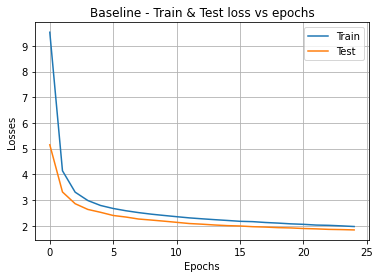

In [ ]:
x = np.arange(0, num_epochs)
plt.plot(x, Train_losses, label='Train')
plt.plot(x, Valid_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Baseline - Train & Test loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

# Sunny

In [ ]:
num_epochs = 80
learning_rate = 5e-6
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_Sunny().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_sunny, datetimes_test_sunny, images_trainval_sunny, images_test_sunny, 
                                                         pv_log_trainval_sunny, pv_log_test_sunny, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )

epoch: 0 train loss: 15.509173258759798 valid loss: 11.928188126625617 test loss: 11.911992242681578
epoch: 1 train loss: 9.6571982782524 valid loss: 7.842347042120504 test loss: 7.936710553290767
epoch: 2 train loss: 6.898240125804945 valid loss: 6.227329359296708 test loss: 6.339750158111805
epoch: 3 train loss: 5.754501911779981 valid loss: 5.375483772339673 test loss: 5.491316496248786
epoch: 4 train loss: 4.990903665542706 valid loss: 4.678557191285605 test loss: 4.785169375144733
epoch: 5 train loss: 4.354757366905427 valid loss: 4.10141840768211 test loss: 4.185116184195902
epoch: 6 train loss: 3.8350215272665693 valid loss: 3.616541828510738 test loss: 3.6686561589177136
epoch: 7 train loss: 3.430919939565442 valid loss: 3.2743837615458813 test loss: 3.294220842684798
epoch: 8 train loss: 3.1333612532972124 valid loss: 3.0111466579446686 test loss: 3.001610829073075
epoch: 9 train loss: 2.9202034863421167 valid loss: 2.8326882736451258 test loss: 2.804111065973835
epoch: 10 tra

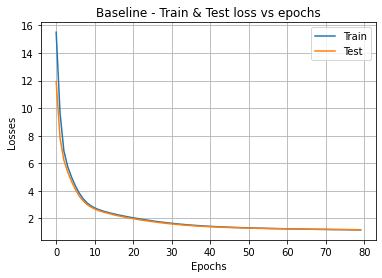

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

# Cloudy

In [ ]:
num_epochs = 100
learning_rate = 5e-6
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_Cloudy().to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_cloudy, datetimes_test_cloudy, images_trainval_cloudy, images_test_cloudy, 
                                                         pv_log_trainval_cloudy, pv_log_test_cloudy, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
cloudy_loss = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 14.003130127583377 valid loss: 12.400249945522242 test loss: 13.467033279840544
epoch: 1 train loss: 11.316606048428275 valid loss: 10.086555032558474 test loss: 11.399977331470842
epoch: 2 train loss: 9.364457443042289 valid loss: 8.532249966145883 test loss: 9.969823842603347
epoch: 3 train loss: 8.08732699953476 valid loss: 7.549794669697004 test loss: 9.01399737177342
epoch: 4 train loss: 7.280200729476392 valid loss: 6.894147798667382 test loss: 8.3348614684204
epoch: 5 train loss: 6.71997955494522 valid loss: 6.402011640990854 test loss: 7.801314653105936
epoch: 6 train loss: 6.280086011574159 valid loss: 6.027080003885644 test loss: 7.395478823902569
epoch: 7 train loss: 5.911831531717987 valid loss: 5.683092506424431 test loss: 7.018999697664251
epoch: 8 train loss: 5.594318391783593 valid loss: 5.39351166273552 test loss: 6.6954092804117336
epoch: 9 train loss: 5.3199890963767835 valid loss: 5.151602541685831 test loss: 6.415992378169274
epoch: 10 train lo

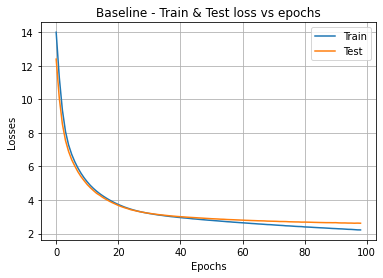

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

# Overcast

In [ ]:
num_epochs = 100
learning_rate = 1e-5
batch_size = 256
batch_size_eval = 256

model = SUNSET.SUNSET_Overcast().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr=learning_rate, weight_decay=weight_decay)

train_loaders = [] 
valid_loaders = [] 

train_loaders, valid_loaders, test_loader = load_creator.create_dataloaders(seq_len, datetimes_trainval_overcast, datetimes_test_overcast, images_trainval_overcast, images_test_overcast, 
                                                         pv_log_trainval_overcast, pv_log_test_overcast, batch_size = batch_size , batch_size_eval = batch_size_eval, split=False)

Train_epoch_losses = []
Valid_epoch_losses = []
Test_epoch_losses = []

for split in range(len(train_loaders)):  
    
    model.apply(weight_reset)
    
    Train_losses = []
    Valid_losses = []
    Test_losses = []

    for epoch in range(num_epochs):

        l_train   =  utils.train(model, train_loaders[split], optimizer, loss_fn, device, seq_len)
        l_val     =  utils.test(model, valid_loaders[split], optimizer, loss_fn, device, seq_len)     
        l_test    =  utils.test(model, test_loader, optimizer, loss_fn, device, seq_len)

        Train_losses.append(math.sqrt(l_train))
        Valid_losses.append(math.sqrt(l_val))
        Test_losses.append(math.sqrt(l_test))
        
        print('epoch: ' + str(epoch) + ' train loss: ' + str(Train_losses[-1]) + ' valid loss: ' + str(Valid_losses[-1]) + ' test loss: ' + str(Test_losses[-1]))
        
        # Early Stopping:
        if epoch > 10 and (epoch - Valid_losses.index(min(Valid_losses)) > 3 ):
            break

    Train_epoch_losses.append(Train_losses) 
    Valid_epoch_losses.append(Valid_losses) 
    Test_epoch_losses.append(Test_losses[Valid_losses.index(min(Valid_losses))]) 
    
    print('split: ' + str(split) + ' test loss: ' + str(Test_epoch_losses[split]) )

print('Mean test loss: ' + str(sum(Test_epoch_losses)/len(Test_epoch_losses)) )
overcast_loss = sum(Test_epoch_losses)/len(Test_epoch_losses)
max_epoch = Valid_losses.index(min(Valid_losses))

epoch: 0 train loss: 5.5924436630447065 valid loss: 4.43420311468607 test loss: 3.276224936208405
epoch: 1 train loss: 3.9210903763834377 valid loss: 3.52795662916482 test loss: 3.249247870660434
epoch: 2 train loss: 3.53569546428833 valid loss: 3.4319838752533975 test loss: 3.065559162898066
epoch: 3 train loss: 3.4397813159866972 valid loss: 3.3588287825578482 test loss: 2.9767121441672018
epoch: 4 train loss: 3.3561311541466847 valid loss: 3.2827702022511978 test loss: 2.946669677311235
epoch: 5 train loss: 3.269477719975321 valid loss: 3.1991996295302814 test loss: 2.894869333093674
epoch: 6 train loss: 3.1811613996334485 valid loss: 3.1049811372505323 test loss: 2.792671205854422
epoch: 7 train loss: 3.083282588450306 valid loss: 3.0032788419096517 test loss: 2.7114337027819344
epoch: 8 train loss: 2.977879812684145 valid loss: 2.896380572990829 test loss: 2.680770607196944
epoch: 9 train loss: 2.865754510583248 valid loss: 2.7786383082069888 test loss: 2.547211063996647
epoch: 10

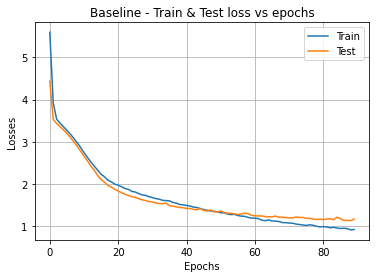

In [ ]:
x = np.arange(0, max_epoch)
plt.plot(x, Train_losses[0:max_epoch], label='Train')
plt.plot(x, Valid_losses[0:max_epoch], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Train & Validation loss vs epochs')
plt.grid(True)
plt.legend()
plt.show()

# Overall Class Prediction

In [ ]:
overall_loss = len(images_test_sunny)*sunny_loss**2 + len(images_test_cloudy)*cloudy_loss**2 + len(images_test_overcast)*overcast_loss**2
overall_loss = overall_loss / (len(images_test_overcast) + len(images_test_sunny) + len(images_test_cloudy))
overall_loss = math.sqrt(overall_loss)
overall_loss

2.310958105830714